In [3]:
#Loading the original tables into dataframes
#df_accident=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv', sep=',', header=0)
#df_vehicle=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1979-2021.csv', sep=',', header=0)
#df_casualty=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1979-2021.csv', sep=',', header=0)

/tmp/ipykernel_6414/229815338.py:2: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accident=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv', sep=',', header=0)


In [2]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data_for_groupby, add_geohash
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel

2022-12-14 10:05:00.825354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 10:05:01.005321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 10:05:01.005350: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 10:05:02.067115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
#Filtering the dataframes to get dta from 1999 only
#df_accident_1999=df_accident[df_accident['accident_year']>=1999]
#df_vehicle_1999=df_vehicle[df_vehicle['accident_year']>=1999]
#df_casualty_1999=df_casualty[df_casualty['accident_year']>=1999]

In [3]:
#Exporting the data from 1999 as csv files --> the new raw data files
#df_accident_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv')
#df_vehicle_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1999-2021.csv')
#df_casualty_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1999-2021.csv')

In [3]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/Clean_data_1999-2021.csv', index_col=0)
df_accidents.head()

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time
4883216,1999,-0.271752,51.715661,3,1,1,25/12/1999,7,09:30
4883217,1999,-0.239977,51.695136,3,2,1,17/12/1999,6,18:38
4883218,1999,-0.270037,51.715096,3,2,2,15/12/1999,4,18:04
4883219,1999,-0.263233,51.711309,2,2,1,02/12/1999,5,04:10
4883220,1999,-0.227225,51.688200,3,4,3,04/12/1999,7,09:51


In [4]:
data_preprocessed=add_geohash(df_accidents,6)
#data_preprocessed.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')

In [5]:
data_preprocessed['date']=pd.to_datetime(data_preprocessed['date'],format='%d/%m/%Y')

In [26]:
hashes=pd.DataFrame(data_preprocessed[['geohash','accident_year']].groupby('geohash').count())
hashes.columns=['Accidents']
hashes.sort_values('Accidents',inplace=True,ascending=False)
hashes.shape

(184578, 1)

In [27]:
hashes=hashes[hashes['Accidents']>=1000]
hashes

,Accidents
geohash,
gcpvj0,2045
gcpvhc,1959
gcpvj4,1871
gcpvj1,1816
gcpuv2,1744
...,...
gcpvps,1019
gcpufz,1019
gcpvq2,1012


In [28]:
data=data_preprocessed[data_preprocessed['geohash'].isin(hashes.index.tolist())]

In [29]:
data.shape

(85173, 10)

In [61]:
FOLD_LENGTH=120 #each fold spans over 10 years
FOLD_STRIDE=12 #we have a fold every 1 year
INPUT_LENGTH=6 #every X_i sequence is 6 months long
TRAIN_TEST_RATIO=.80 
OUTPUT_LENGTH=1 #we want to predict the number of accidents in the next month (y_i length)
SEQUENCE_STRIDE = 1

In [62]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for hash in hashes.index.tolist():
    data_hash=data[data['geohash']==hash]
    data_series=data_for_analysis(data,'M')
    folds=mlmodel.get_folds(data_series,FOLD_LENGTH,FOLD_STRIDE)
    fold=folds[4]
    (fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
    X_train_fold, y_train_fold = mlmodel.get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
    X_test_fold, y_test_fold = mlmodel.get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)   
    X_train.append(X_train_fold)
    X_test.append(X_test_fold)
    y_train.append(y_train_fold)
    y_test.append(y_test_fold)
np.array(X_train).shape, np.array(y_train).shape

((68, 90, 6, 1), (68, 90, 1, 1))

In [63]:
X_train_all_hashes=np.array(X_train[0])
X_test_all_hashes=np.array(X_test[0])
y_train_all_hashes=np.array(y_train[0])
y_test_all_hashes=np.array(y_test[0])

for i in range(1,np.array(X_train).shape[0]):
    X_train_all_hashes=np.vstack((X_train_all_hashes,X_train[i]))
    y_train_all_hashes=np.vstack((y_train_all_hashes,y_train[i]))
    
for i in range(1,np.array(X_test).shape[0]):
    X_test_all_hashes=np.vstack((X_test_all_hashes,X_test[i]))
    y_test_all_hashes=np.vstack((y_test_all_hashes,y_test[i]))

In [64]:
X_train_all_hashes.shape

(6120, 6, 1)

In [65]:
y_train_all_hashes.shape

(6120, 1, 1)

In [80]:
model = mlmodel.init_model(X_train_all_hashes)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30)                3840      
                                                                 
 dense_12 (Dense)            (None, 20)                620       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-traina

In [81]:
model, history = mlmodel.fit_model(model,X_train_all_hashes,y_train_all_hashes)

Epoch 1/500
268/268 [==============================] - 7s 14ms/step - loss: 82545.2109 - mae: 283.0533 - val_loss: 53065.9727 - val_mae: 226.1390
Epoch 2/500
268/268 [==============================] - 3s 11ms/step - loss: 21820.3711 - mae: 124.9588 - val_loss: 3135.3206 - val_mae: 46.3920
Epoch 3/500
268/268 [==============================] - 3s 10ms/step - loss: 12766.9375 - mae: 91.4553 - val_loss: 2967.1812 - val_mae: 45.0031
Epoch 4/500
268/268 [==============================] - 3s 10ms/step - loss: 12459.7754 - mae: 90.7635 - val_loss: 2692.2380 - val_mae: 42.6880
Epoch 5/500
268/268 [==============================] - 3s 10ms/step - loss: 12066.3398 - mae: 88.6056 - val_loss: 2744.3506 - val_mae: 43.5048
Epoch 6/500
268/268 [==============================] - 3s 10ms/step - loss: 11483.2930 - mae: 86.8421 - val_loss: 2835.9058 - val_mae: 44.3466
Epoch 7/500
268/268 [==============================] - 3s 10ms/step - loss: 11470.1113 - mae: 87.1781 - val_loss: 2806.1729 - val_mae: 44.

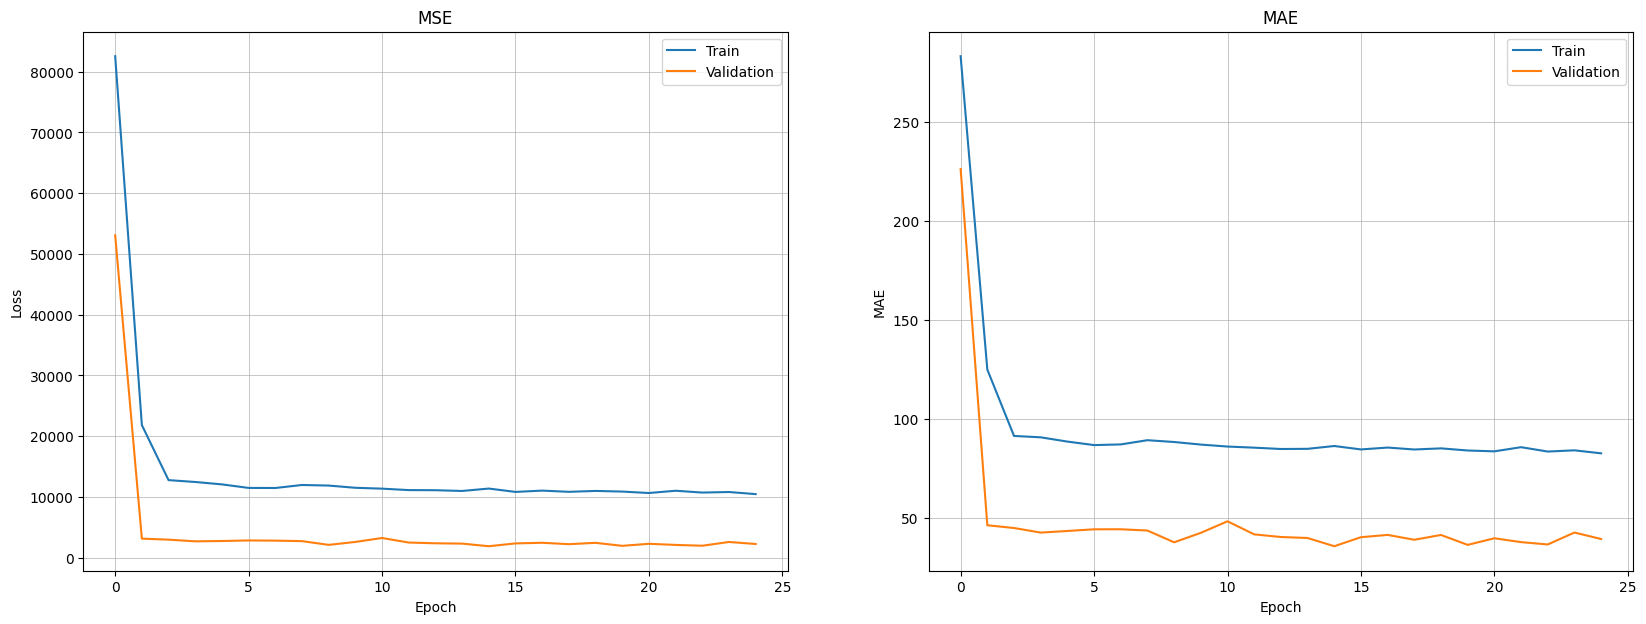

In [82]:
mlmodel.plot_history(history);

In [69]:
baseline_model=mlmodel.init_baseline(OUTPUT_LENGTH)

In [83]:
y_pred=np.round(np.array(model.predict(X_test_all_hashes)[-1])).astype(int)
y_bas_pred=baseline_model.predict(X_test_all_hashes)[-1]

51/51 [==============================] - 0s 2ms/step


In [84]:
y_pred,y_bas_pred,y_test_all_hashes[-1,:,:]

(array([284]), array([[306]]), array([[260]]))

In [88]:
X = data_preprocessed[data_preprocessed['geohash']=='gcpvj0'].tail(6)

In [89]:
X

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,geohash
8622439,2021,-0.124845,51.508820,3,2,1,2021-11-11,5,04:32,gcpvj0
8622987,2021,-0.122484,51.506300,3,2,1,2021-11-18,5,14:10,gcpvj0
8623160,2021,-0.125402,51.508595,3,3,1,2021-11-21,1,03:43,gcpvj0
8623388,2021,-0.121712,51.507205,2,1,2,2021-11-24,4,12:58,gcpvj0
8625156,2021,-0.126665,51.507320,2,2,1,2021-12-19,1,21:00,gcpvj0
8625294,2021,-0.126209,51.508248,3,1,1,2021-12-22,4,11:05,gcpvj0


In [87]:
model.predict(X)

ValueError: in user code:

    File "/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_6' (type Sequential).
    
    Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_6' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None
